In [1]:
from openvino.runtime import Core
import numpy as np
import torch
from diffusers import DDPMScheduler
from transformers import CLIPTokenizer
from PIL import Image

core = Core()

# Load the compiled OpenVINO IR models
ov_text = core.compile_model("openvino_models/text_encoder.xml", "CPU")
ov_unet = core.compile_model("openvino_models/unet.xml", "CPU")
ov_vae  = core.compile_model("openvino_models/vae_decoder.xml", "CPU")

text_req = ov_text.create_infer_request()
unet_req = ov_unet.create_infer_request()
vae_req  = ov_vae.create_infer_request()

In [2]:
def ov_infer(request, inputs):
    return request.infer(inputs)

In [3]:
def generate_image_openvino(prompt, steps=50, guidance=7.5):
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

    # ------------------------------
    # Encode text
    # ------------------------------
    tokens = tokenizer(
        prompt,
        padding="max_length",
        truncation=True,
        max_length=77,
        return_tensors="pt"
    )
    uncond = tokenizer(
        "",
        padding="max_length",
        truncation=True,
        max_length=77,
        return_tensors="pt"
    )

    ids = tokens["input_ids"].numpy()
    mask = tokens["attention_mask"].numpy()

    un_ids = uncond["input_ids"].numpy()
    un_mask = uncond["attention_mask"].numpy()

    # OV text encoder
    cond_emb = ov_infer(text_req,
                        {"input_ids": ids,
                         "attention_mask": mask})["last_hidden_state"]

    uncond_emb = ov_infer(text_req,
                          {"input_ids": un_ids,
                           "attention_mask": un_mask})["last_hidden_state"]

    # Combine for CFG
    context = np.concatenate([uncond_emb, cond_emb], axis=0).astype(np.float32)

    # ------------------------------
    # Diffusion loop
    # ------------------------------
    LATENT = 16
    scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
    scheduler.set_timesteps(steps)

    latents = torch.randn((1, 4, LATENT, LATENT)).numpy().astype(np.float32)
    latents *= scheduler.init_noise_sigma

    for t in scheduler.timesteps:
        # duplicate (uncond + cond)
        latent_input = np.concatenate([latents, latents], axis=0).astype(np.float32)

        unet_input = {
            "latent":   latent_input,
            "timestep": np.array([float(t)], dtype=np.float32),
            "context":  context
        }

        noise_pred = ov_infer(unet_req, unet_input)["noise_pred"]

        # CFG
        un_pred, cond_pred = np.split(noise_pred, 2)
        guided = un_pred + guidance * (cond_pred - un_pred)

        # scheduler step
        latents = scheduler.step(
            torch.from_numpy(guided),
            torch.tensor(t),
            torch.from_numpy(latents)
        ).prev_sample.numpy().astype(np.float32)

    # ------------------------------
    # Decode latents using OpenVINO VAE
    # ------------------------------
    latents = latents / 0.18215

    img_latents = ov_infer(vae_req, {"latent": latents})["image"]

    # ------------------------------
    # Convert to RGB image
    # ------------------------------
    img = torch.tensor(img_latents)
    img = (img / 2 + 0.5).clamp(0, 1)

    img = img.permute(0, 2, 3, 1).squeeze(0).numpy()
    img = (img * 255).astype(np.uint8)

    return Image.fromarray(img)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_23906/591751339.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t),


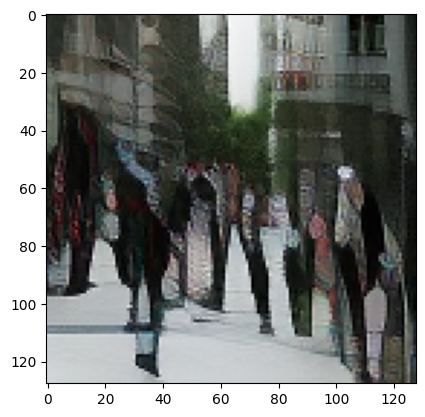

In [6]:
import matplotlib.pyplot as plt
img = generate_image_openvino("people walking on a street", steps=50)
plt.imshow(img)